In [38]:
import keras
import numpy as np
from moviepy.editor import VideoFileClip
import random
import os

import keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf

import pickle

from tqdm import tqdm

import pandas

In [2]:
data_dir = 'recurrent'
model_name = 'initialrecurrent16.10-0.00'
session = '180605_000'
windowSize = 15

In [3]:
clip = VideoFileClip(os.path.join(data_dir, 'sessions', session, 'runTop.mp4'))

In [4]:
def meanDistance(y_true, y_pred):
    in_shape = tf.shape(y_true)

    # Flatten height/width dims
    flat_true = tf.reshape(y_true, [in_shape[0], -1, in_shape[-1]])
    flat_pred = tf.reshape(y_pred, [in_shape[0], -1, in_shape[-1]])

    # Find peaks in linear indices
    idx_true = tf.argmax(flat_true, axis=1)
    idx_pred = tf.argmax(flat_pred, axis=1)

    # Convert linear indices to subscripts
    rows_true = tf.floor_div(tf.cast(idx_true,tf.int32), in_shape[2])
    cols_true = tf.floormod(tf.cast(idx_true,tf.int32), in_shape[2])
    
    rows_pred = tf.floor_div(tf.cast(idx_pred, tf.int32), in_shape[2])
    cols_pred = tf.floormod(tf.cast(idx_pred, tf.int32), in_shape[2])
    
    row_diff = tf.square(tf.subtract(tf.cast(rows_true, tf.float32), tf.cast(rows_pred, tf.float32)))
    col_diff = tf.square(tf.subtract(tf.cast(cols_true, tf.float32), tf.cast(cols_pred, tf.float32)))
    distances = tf.sqrt(tf.add(row_diff, col_diff))
    
    return tf.reduce_mean(distances)

In [5]:
net = keras.models.load_model(os.path.join('models', model_name+'.h5'), custom_objects={'meanDistance': meanDistance})

In [6]:
def getImg(frame):
        toRet = []
        for i in range(frame-windowSize+1, frame+1):
            img = clip.get_frame(i/clip.fps)
            x = np.asarray(img, dtype=K.floatx())[:,:,0]/255.
            x = x.reshape((x.shape[0], x.shape[1], 1))
            toRet.append(x)
        return toRet

In [7]:
testData = pickle.load(open('recurrent/test.pickle', 'rb'))

In [8]:
testData = [i for i in testData if i['session'] == session]

In [9]:
def findPt(predMap):
    in_shape = predMap.shape

    # Flatten height/width dims
    flat_true = np.reshape(predMap, [-1])

    # Find peaks in linear indices
    idx_true = np.argmax(flat_true)

    # Convert linear indices to subscripts
    rows_true = idx_true//in_shape[1]
    cols_true = idx_true%in_shape[1]
    
    return (cols_true, rows_true)

In [62]:
errors =[[],[],[],[]]

tracked = ['paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top']

for frame in tqdm(testData):
    test = getImg(frame['frameNum'])
    test = np.asarray(test)
    mean = np.reshape([0.257], [1,1,1,1])
    std = np.reshape([0.288], [1,1,1,1])
    toPred = np.array([test])
    toPred-=mean
    toPred/=std
    preds = net.predict(toPred)
    for j in range(15):
        for i in range(4):
            pt = findPt(preds[0,j,:,:,i])
            errors[i].append(np.sqrt((pt[0]-trackedFeatures[session][frame['frameNum']-14+j][tracked[i]][0])**2+(pt[1]-trackedFeatures[session][frame['frameNum']-14+j][tracked[i]][1])**2))

100%|██████████| 50/50 [00:07<00:00,  6.88it/s]


In [63]:
print(','.join(tracked))
for i in range(len(errors[0])):
    print(','.join(str(j[i]) for j in errors))

paw1LH_top,paw2LF_top,paw3RF_top,paw4RH_top
3.0846487501,2.42604471073,1.56792242162,0.962128150882
2.47293663365,5.75598290211,0.809532206499,0.325796069987
2.10985477836,5.11058354691,3.66980840703,2.08475196947
0.480168972163,2.02817218783,2.55806690896,3.02785309715
2.05480070751,5.41318174607,2.52994944136,3.76857444974
1.98045610489,2.76451311724,2.08680174314,1.54981201039
3.34766928278,0.553776642562,1.09149621813,1.33857414205
1.98155415878,1.09172273053,1.28870611412,2.81687526383
1.42293637374,1.07743779555,2.0777178276,1.83345271773
1.83813366856,0.878696266647,0.777594929245,0.87015412601
1.62448937807,2.95115250273,1.04342361205,5.10620943538
0.504154980115,2.52463310768,0.807832301304,42.874738164
3.64131506372,1.7224362151,0.099873802406,39.2213407819
1.58422636298,1.24538064612,0.433626475763,5.28945179456
2.40823912587,2.10753053791,0.372361219125,2.32073653805
1.45691409188,0.337229052571,7.05106876899,9.2345498966
2.34020037056,1.20997048395,2.54923961587,2.83424079

In [69]:
errors2 =[[],[],[],[]]

tracked = ['paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top']

for frame in tqdm(testData):
    test = getImg(frame['frameNum'])
    test = np.asarray(test)
    mean = np.reshape([0.257], [1,1,1,1])
    std = np.reshape([0.288], [1,1,1,1])
    toPred = np.array([test])
    toPred-=mean
    toPred/=std
    preds = netnon.predict(np.expand_dims(toPred[0,14],axis=0))
    j = 14
    for i in range(4):
        pt = findPt(preds[0,:,:,i])
        errors2[i].append(np.sqrt((pt[0]-trackedFeatures[session][frame['frameNum']-14+j][tracked[i]][0])**2+(pt[1]-trackedFeatures[session][frame['frameNum']-14+j][tracked[i]][1])**2))

100%|██████████| 50/50 [00:04<00:00, 10.88it/s]


In [70]:
print(','.join(tracked))
for i in range(len(errors2[0])):
    print(','.join(str(j[i]) for j in errors2))

paw1LH_top,paw2LF_top,paw3RF_top,paw4RH_top
1.15452976373,1.96149142091,1.04329699876,3.56033896478
2.15642130866,0.773172452566,0.914475882577,1.34194925505
1.30691090939,1.26970039246,1.77714760166,3.25515736228
4.10431766313,1.07006875091,0.613040459924,1.13598677228
4.23182606011,0.986639943676,8.78683406273,2.56534544681
6.14754419359,1.34730060843,1.28355515804,5.34206660872
2.91087174114,1.85665386498,0.494079441766,1.05532446027
2.68860470694,1.96605822177,5.28418844817,2.22820905841
24.0806695059,2.39633964426,2.81117094762,1.33597907758
11.4255020245,2.69621370755,1.63364276558,3.25520341809
2.46519344464,1.51310885951,2.4524873856,2.10118557003
27.6159523652,2.93550424896,1.81326457972,6.05646054118
1.96601038116,0.78958931047,2.95882650714,3.15714968689
3.06903946766,1.83858209102,1.53282470689,2.9872249628
3.26771850828,4.36909492005,0.96403106886,2.33825010895
4.71382089623,1.55169830577,2.12045374973,0.620734247854
7.33668783172,0.989745875421,0.47434118896,0.32633950146

In [101]:
def occlude(frame, pts):
    sp = frame.shape
    for pt in pts:
        pt = (int(pt[0]), int(pt[1]))
        for x in range(max(0, pt[1]-20), min(sp[0], pt[1]+20)):
            for y in range(max(0, pt[0]-20), min(sp[1], pt[0]+20)):
                frame[x][y] = 0
    return frame

In [39]:
neededFrames = {}
trackedFeatures = {}
cols = list(range(19))
framenumName = 'Unnamed: 0'
for frame in testData:
    if frame['session'] not in neededFrames:
        neededFrames[frame['session']] = set()
    neededFrames[frame['session']].update(list(range(frame['frameNum']-windowSize+1, frame['frameNum']+1)))
for session in neededFrames:
    tmp = pandas.read_csv(os.path.join(data_dir, 'sessions', session, 'trackedFeaturesRaw.csv'), usecols=cols)
    tmp = tmp.to_dict('records')
    tmp = {int(sample[framenumName]): {feature: (sample[feature], sample[feature+'.1']) for feature in tracked} for sample in tmp}
    if session not in trackedFeatures:
        trackedFeatures[session] = {i: tmp[i] for i in neededFrames[session]}
    else:
        trackedFeatures[session].update({i: tmp[i] for i in neededFrames[session]})

In [46]:
test = getImg(testData[0]['frameNum'])
test = np.asarray(test)

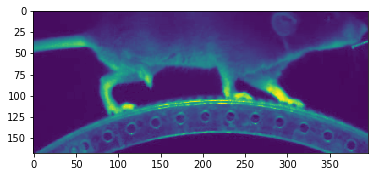

(168, 396)


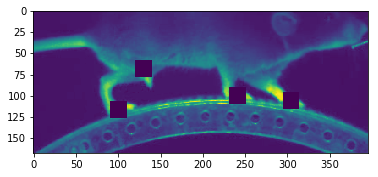

In [47]:
plt.imshow(test[14,:,:,0])
plt.show()
plt.imshow(occlude(test[14,:,:,0], [trackedFeatures[session][testData[0]['frameNum']][i] for i in tracked]))
plt.show()

In [49]:
mean = np.reshape([0.257], [1,1,1,1])
std = np.reshape([0.288], [1,1,1,1])
toPred = np.array([test])
toPred-=mean
toPred/=std

In [50]:
preds = net.predict(toPred)

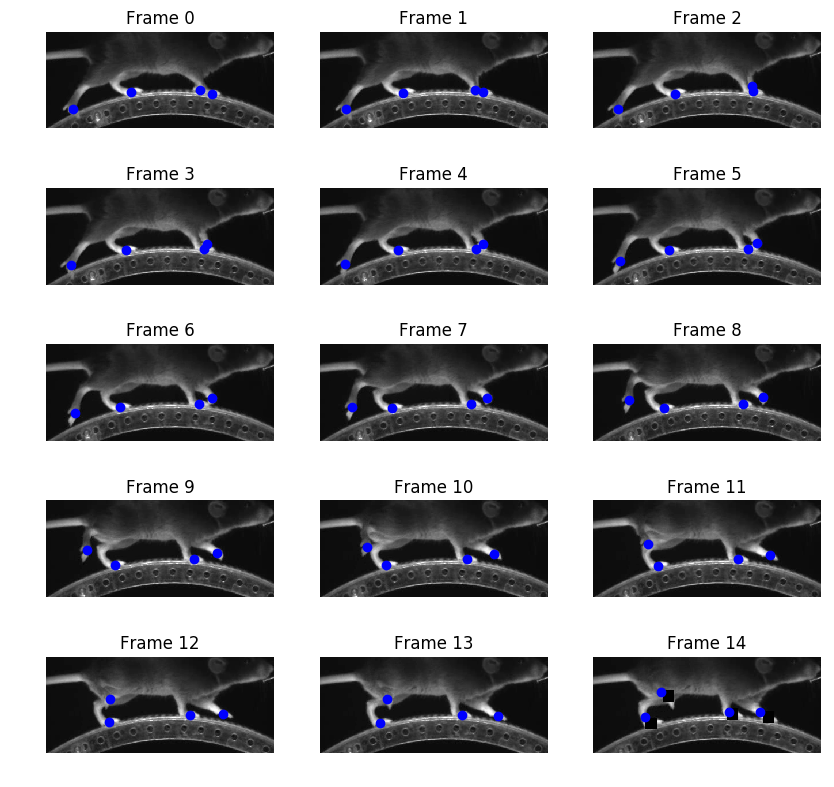

In [51]:
fig = plt.figure()
fig.set_size_inches(10, 10)
fig.set_dpi(100)
ax = fig.add_axes([0.,0.,1.,1.])
ax.axis('off')
for j in range(15):
    plt.subplot(5, 3, j+1)
    plt.title('Frame '+str(j))
    plt.imshow(np.repeat(test[j], 3, axis=2))
    for i in range(4):
        plt.plot(*findPt(preds[0,j,:,:,i]), 'bo')
    plt.axis('off')
plt.show()

In [52]:
nonRec = 'initialnonrecurrent.10-0.00'
netnon = keras.models.load_model(os.path.join('models', nonRec+'.h5'), custom_objects={'meanDistance': meanDistance})

In [55]:
pred2 = netnon.predict(np.expand_dims(toPred[0,14], axis=0))

(-0.5, 395.5, 167.5, -0.5)

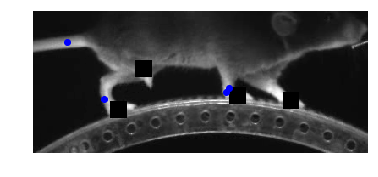

In [57]:
plt.imshow(np.repeat(test[14], 3, axis=2))
for i in range(4):
    plt.plot(*findPt(pred2[0,:,:,i]), 'bo')
plt.axis('off')

In [117]:
errors =[[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]

tracked = ['paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top']

for frame in tqdm(testData):
    test = getImg(frame['frameNum'])
    test = np.asarray(test)
    for k in range(15):
        occlude(test[14-k,:,:,0], [trackedFeatures[session][testData[0]['frameNum']-k][i] for i in tracked])
        mean = np.reshape([0.257], [1,1,1,1])
        std = np.reshape([0.288], [1,1,1,1])
        toPred = np.array([test])
        toPred-=mean
        toPred/=std
        preds = net.predict(toPred)
        for j in range(k+1):
            for i in range(4):
                pt = findPt(preds[0,14-j,:,:,i])
                errors[k].append(np.sqrt((pt[0]-trackedFeatures[session][frame['frameNum']-j][tracked[i]][0])**2+(pt[1]-trackedFeatures[session][frame['frameNum']-j][tracked[i]][1])**2))

100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


In [85]:
errorAvg = [np.average(i) for i in errors]

In [93]:
print('\n'.join([str(i) for i in errorAvg]))

27.9187576497
34.0661272088
40.7416304537
46.3364225391
46.46294623
49.1472107402
52.4631161342
52.6983251271
52.2370523974
51.0512789716
50.497884078
49.5203197879
49.8763732353
51.7479796821
52.9868931676
nan


In [113]:
frame = testData[0]
test = getImg(frame['frameNum'])
test = np.asarray(test)
for k in range(2):
    occlude(test[14-k,:,:,0], [trackedFeatures[session][testData[0]['frameNum']-k][i] for i in tracked])
mean = np.reshape([0.257], [1,1,1,1])
std = np.reshape([0.288], [1,1,1,1])
toPred = np.array([test])
toPred-=mean
toPred/=std
preds = net.predict(toPred)

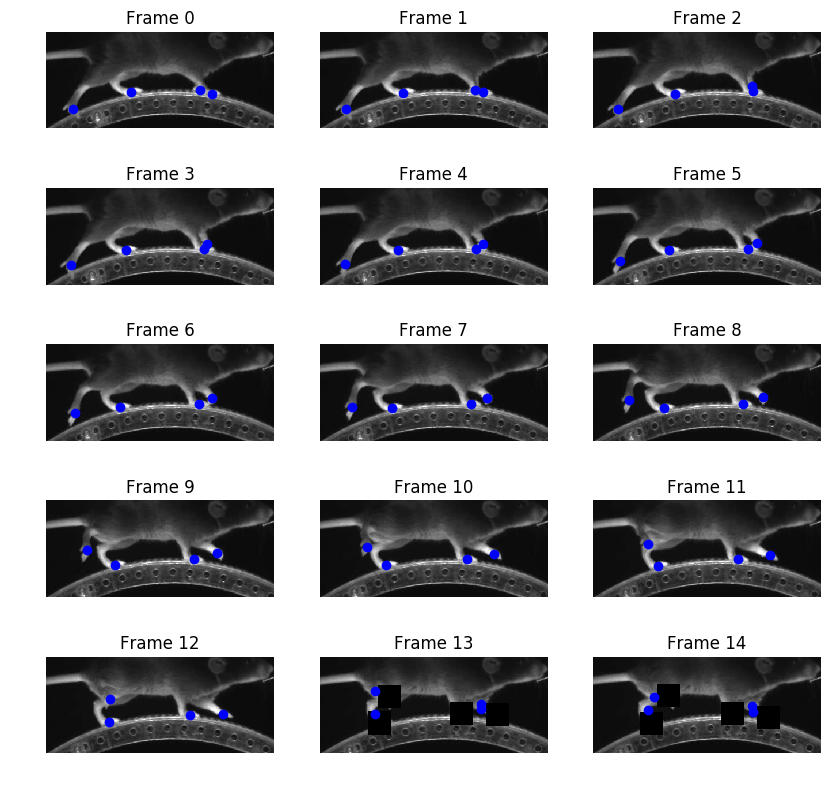

In [114]:
fig = plt.figure()
fig.set_size_inches(10, 10)
fig.set_dpi(100)
ax = fig.add_axes([0.,0.,1.,1.])
ax.axis('off')
for j in range(15):
    plt.subplot(5, 3, j+1)
    plt.title('Frame '+str(j))
    plt.imshow(np.repeat(test[j], 3, axis=2))
    for i in range(4):
        plt.plot(*findPt(preds[0,j,:,:,i]), 'bo')
    plt.axis('off')
plt.show()

In [108]:
errors =[]

tracked = ['paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top']

for frame in tqdm(testData):
    test = getImg(frame['frameNum'])
    test = np.asarray(test)
    for k in range(15):
        occlude(test[14-k,:,:,0], [trackedFeatures[session][testData[0]['frameNum']-k][i] for i in tracked])
    mean = np.reshape([0.257], [1,1,1,1])
    std = np.reshape([0.288], [1,1,1,1])
    toPred = np.array([test])
    toPred-=mean
    toPred/=std
    preds = np.array([[np.squeeze(netnon.predict(np.expand_dims(i, axis=0))) for i in toPred[0]]])
    for j in range(15):
        for i in range(4):
            pt = findPt(preds[0,14-j,:,:,i])
            errors.append(np.sqrt((pt[0]-trackedFeatures[session][frame['frameNum']-j][tracked[i]][0])**2+(pt[1]-trackedFeatures[session][frame['frameNum']-j][tracked[i]][1])**2))

100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


In [110]:
np.average(errors)

51.52050872323656

In [116]:
print('\n'.join([str(i) for i in errors]))

49.2381934699
29.9351066518
33.8974921815
147.480905724
35.7889984392
224.661967409
31.9038553975
162.279856929
176.268419088
88.7702327776
174.046480316
170.837604215
168.109567491
213.015063382
173.2987974
44.6252529232
162.896976634
34.2112809357
171.135821706
190.567073923
156.350941042
201.020495286
167.538914043
58.1948376906
151.726349667
194.949940484
162.395980342
55.7731209692
33.9255821182
188.090788936
168.344252233
71.2417512063
32.9258036684
180.413893054
166.553360197
79.8299341915
25.5024370493
174.862073829
168.692062778
88.2237729109
75.6738467755
167.466655796
165.497155048
95.3172408413
33.6983441967
165.956532684
163.436263905
74.1141826849
32.5954778786
156.950632829
169.09965959
95.9779534299
125.022463596
150.083672447
169.213272787
96.0674283686
127.937211735
141.729930891
168.797950452
96.741130486
34.7473725305
135.954601937
4.27776652758
3.7217260444
31.2393466818
56.4704530051
9.0351392623
0.513237322926
175.923885419
42.656788232
13.8078363477
4.7574259376

In [120]:
for i in range(len(errors[14])):
    print(','.join(str(j[i]) if i<len(j) else '' for j in errors))

44.5465276465,48.4021653761,48.4021653761,48.4021653761,48.4021653761,48.4021653761,48.4021653761,48.4021653761,48.4021653761,48.4021653761,48.4021653761,48.4021653761,48.4021653761,48.4021653761,48.4021653761,
204.384065622,211.266279524,203.409203444,203.409203444,211.266279524,202.441599391,202.441599391,202.441599391,202.441599391,202.441599391,202.441599391,202.441599391,202.441599391,202.441599391,202.441599391,
37.6789326722,35.156477024,149.531037755,149.531037755,149.531037755,149.531037755,149.531037755,148.532979367,148.532979367,148.532979367,148.532979367,148.532979367,148.532979367,148.532979367,148.532979367,
146.290977145,144.497426702,144.497426702,144.497426702,144.497426702,144.497426702,144.497426702,144.497426702,144.497426702,144.497426702,144.497426702,144.497426702,144.497426702,144.497426702,144.497426702,
22.541788093,58.289348131,58.289348131,58.289348131,59.2763249622,59.2763249622,59.2763249622,59.2763249622,59.2763249622,59.2763249622,59.2763249622,59.2763

In [122]:
for j in errors:
    print(len(j))

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
0
